# Initial Work for Test Network


## Notebook Setup

<div hidden>
$\usepackage{cancel}$
$\usepackage{amssymb}$
</div>

In [9]:
# Required packages
#!pip install torch torchvision pandas numpy matplotlib scipy plotly tensorboard onyx

In [1]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [3]:
from models.simpleFork import Simple, Fork

import os
from collections import namedtuple
from timeit import default_timer
import re
from datetime import datetime

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import svd, diagsvd

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.io import read_image, ImageReadMode
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

### Per-run user defined variables

In [4]:
# Define the machine being used
machine = "Macbook"
# machine = "PC"

## FORMAT: {machine}, {model}, {datetime}
state_dict_str = "{}_{}_state-dict_{}.pt"
state_dict_notime = "{}_{}_state-dict"
checkpoint_dict_str = "{}_{}_checkpoint_{}.tar"
checkpoint_dict_notime = "{}_{}_checkpoint"

Checkpoint = namedtuple("Checkpoint", ["model", "epoch", "loss", "validation_loss", "opt_state_dict"])
# data_dir = os.path.join("..", "data")
# output_dir = os.path.join(data_dir, "output")
data_dir = os.path.join("..")
output_dir = os.path.join(data_dir, "data", "output")


## Data 

We remove the channels in the images (convert to grayscale) to more closely mimic the actual plasma dataset

* [Helpful Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

#### Data Augmentation
TODO: Cropping, rotating, scaling, reflecting

#### Normalization
* Normalize each image with respect to its unit Frobenius norm

### Dataset

In [5]:
class YtVidsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
        self._folder_name = "test_imgs"
        self._num_folders = 3
        self._image_names = ["imageA", "imageB", "imageC"]
        self._folder_lens = [len([f for f in 
                                    os.listdir(os.path.join(img_dir, self._folder_name + str(i))) if f.endswith("jpg")])
                                    for i in range(self._num_folders)]
        self._folder_idxs = np.cumsum(self._folder_lens) - 1
        self._len = sum(self._folder_lens)


    def __len__(self):
        return self._len

    
    def __getitem__(self, idx):
        folder_num = np.searchsorted(self._folder_idxs, idx)
        img_num = idx if folder_num == 0 else idx - self._folder_idxs[folder_num - 1] - 1
        img_path = os.path.join(self.img_dir, self._folder_name + str(folder_num), f"{self._image_names[folder_num]}_{img_num}.jpg")
        # Load in as a 2d image (no channels)
        image = read_image(img_path, mode=ImageReadMode.GRAY)[0, :, :].to(torch.float32)
        # Normalize w.r.t. unit Frobenius norm
        image = nn.functional.normalize(image, dim=(0, 1))
        if self.transform is not None:
            image = self.transform(image)
        return image


In [6]:
batch_size = 5

# Load and split the data, and prep for being fed into the NN
data = YtVidsDataset(data_dir)
# Divide data into train, validation, test
train_data, validation_data, test_data = random_split(data, [0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)

6741 <class 'torch.Tensor'> torch.Size([54, 96])
tensor([[0.0160, 0.0155, 0.0152,  ..., 0.0163, 0.0162, 0.0162],
        [0.0156, 0.0158, 0.0155,  ..., 0.0160, 0.0159, 0.0158],
        [0.0148, 0.0154, 0.0150,  ..., 0.0158, 0.0157, 0.0156],
        ...,
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0147, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0141],
        [0.0146, 0.0146, 0.0145,  ..., 0.0140, 0.0136, 0.0142]])


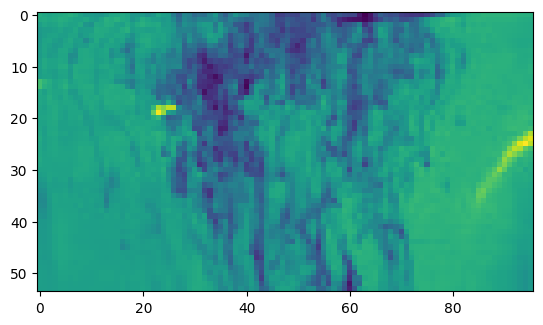

In [7]:
plt.imshow(data[2000])
print(len(data), type(data[0]), data[244].shape)
print(data[2000])

## Hyperparameters


### Structure


#### From papers
* **Non-alternating/nonnegative Matrix Factorization (NMF)**: Classical deep NMF for a non-negative matrix X ∈ Rm×n + can be described as follows: first, X is decomposed as X ≈ U0V 0 where U 0 ∈ Rm×r0 +  and V 0 ∈ Rr0×n + . The coding matrix V 0 is then further decomposed as V 0 ≈ U 1V 1 where U 1 ∈ Rr0×r1 +  and V 1 ∈ Rr1×n +. The procedure is repeated until a pre-fixed number of layers is reached. [[2]](#r2)
* **deep alternating non-negative matrix factorisation (DA-NMF)**: we propose to factorise the basis and coding matrices in an alternating order along the layers. [[2]](#r2)
    * Uses approx 6-8 layers

<img src="images/r2_fig1.png" alt="Drawing" style="width: 400px;"/>
<!-- ![image.png](images/r2_fig1.png) -->


### L-System
* Using L (Lindenmayer) Systems to define strucure?
* Node types:
    * Terminating (1 -> 0)
    * Splitting (1 -> 2)
    * Unifying (2 ->1)
    * Direct (1 -> 1)
    * Starting (0 -> 1)


### Loss Function
We use methods defined in [[1]](#r1) to define our loss function <!-- $\mathcal{L}$ \\ -->

$$
\min_{\substack{U \in \real^{m\times r} \\ V \in \real^{r\times n}}} ||X - ReLU(UV)||^2_F ,
$$
Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the rectified linear low rank representation matrices $UV$

#### From paper

Eq. 10-11 [[2]](#r2)

TODO


### Optimizer

Adam?



## TODO

* compare against SVD 4, using rank 6 for NN (or bigger)
* Use a different algo where we pre-give the rank, better alg: `scipy.sparse.linalg.svds`, tol=0.001
* Go as big as I can, log space increase in size
* Warm starting (initializing) the SVD algorithm, using the NN for the warm start
    * `scipy.linalg.qr`
    * Randomized Numerical Linear Algebra: Foundations & Algorithms (Per-Gunnar Martinsson, University of Texas at Austin Joel A. Tropp, California Institute of Technology)
* Compare rank vs err (loss) for SVD vs NN, and see how many more ranks it is to get comparable err


## Model Definition

### General params

In [8]:
# Select device to use for compute power
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
use_cuda = device == "cuda"

# Params
img_size = (54, 96)
rank = 6

Using cpu device


### Various Models

In [9]:
class SimpleNeg(nn.Module):
    """ Model allowing negative values, same structure as Simple (fork at last layer)
    """
    def __init__(self):
        super().__init__()
        
        self.input = nn.Flatten(start_dim=1)

        self.seq = nn.Sequential(nn.Sequential(nn.Linear(np.prod(img_size), layer_dims[0]), nn.Tanh()))
        for i, r in enumerate(layer_dims[1:]):
            self.seq = self.seq.append(nn.Sequential(nn.Linear(layer_dims[i], r), nn.Tanh()))
        
        self.U = nn.Sequential(nn.Linear(layer_dims[-1], img_size[0] * rank),
                               nn.Unflatten(1, (img_size[0], rank)),
                               nn.Tanh())
        self.V = nn.Sequential(nn.Linear(layer_dims[-1], rank * img_size[1] ),
                               nn.Unflatten(1, (rank, img_size[1])),
                               nn.Tanh())

    def get_hyperparameters():
        return dict(
            layer_dims = layer_dims,
            rank = layer_dims[-1],
            img_size = img_size,
            desc = "Allows negative values, same structure as Simple (fork at last layer)"
        )
        
    def forward(self, x):
        input = self.input(x)
        seq_output = self.seq(input)
        
        U = self.U(seq_output)
        V = self.V(seq_output)

        return U, V


### Model: Variations

TODO:
* ~Simple with no nonnegativity constraints (sigmoid activation)~
    * ~Allow negativity at every step except after UV, aka ReLU(UV) or |UV| (relu better)~
* Different activation layers
* Different structure
    * Try forking at beginning
* Define new layer
    * Instead of flattening and using a linear layer, doing a either side multiply of the matrix input: A\*X\*B where A: n_1 x m, X: m x n, B: n x n_2
* try 2d convolutional layers

In [10]:
layer_dims = (500, 400, 300, 200, 100, 100)
# model_neg = SimpleNeg().to(device)
# print(model_neg, model_simple)
# model_simple = Simple(layer_dims=layer_dims).to(device)
# print(model_simple)
# print(model_simple.get_name(), model_simple.get_hyperparameters())

model_fork = Fork().to(device)
print(model_fork)
print(model_fork.get_name(), model_fork.get_hyperparameters())

Fork(
  (input): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=500, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=400, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=300, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (U): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=300, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=300, out_features=200, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): L

In [19]:
# datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
# next((x for x in sorted(os.listdir(data_dir + "/test_imgs1")) if x.startswith("image")), None)
os.listdir(data_dir)
# mname = model_neg.__class__.__name__
# checkpoint_dict_notime.format(machine="fff", model=mname)
# datetime.now().strftime('%Y-%m-%d_%H%M%S')

['.DS_Store',
 'LICENSE',
 'test_imgs2',
 'README.md',
 '.gitignore',
 '.git',
 '-svasudevanmbp.gitignore',
 'data',
 'test_imgs1',
 'test_imgs0',
 'src']

#### DANMF Implementation

In [20]:
# Must be even number of layers
# layer_dims = (300, 200, 150, 100, 40, 20)

layer_dims = (150, 100, 70, 50, 30, 10)

class DANMF(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Flatten(start_dim=1)
        
        self.U = nn.ModuleDict()
        self.V = nn.ModuleDict()
        self.seq = nn.ModuleList()
        
        for i, r in enumerate(layer_dims):
            if (i % 2 == 0): # Even layers
                if (i == 0):
                    prev = img_size
                    new_V = (r, img_size[1])
                    new_U = (img_size[0], r)
                else:
                    prev = (layer_dims[i-2], layer_dims[i-1])
                    new_V = (r, layer_dims[i-1])
                    new_U = (layer_dims[i-2], r)
                self.seq = self.seq.append(nn.Sequential(nn.Linear(np.prod(prev), np.prod(new_V)), nn.ReLU()))
                self.U.update({str(i): nn.Sequential(nn.Linear(np.prod(prev), np.prod(new_U)),
                                                 nn.Unflatten(1, new_U),
                                                 nn.ReLU()
                                                )})
            else:
                if (i == len(layer_dims) - 1):
                    self.U.update({str(i): nn.Sequential(nn.Linear(layer_dims[i-1] * layer_dims[i-2], layer_dims[i-1] * r),
                                                     nn.Unflatten(1, (layer_dims[i-1], r)),
                                                     nn.ReLU()
                                                    )})
                    self.V.update({str(i): nn.Sequential(nn.Linear(layer_dims[i-1] * layer_dims[i-2], r * layer_dims[i-2]),
                                                     nn.Unflatten(1, (r, layer_dims[i-2])),
                                                     nn.ReLU()
                                                    )})
                else:
                    if (i == 1):
                        prev = (layer_dims[i-1], img_size[1])
                        new_U = (layer_dims[i-1], r)
                        new_V = (r, img_size[1])
                    else:
                        prev = (layer_dims[i-1], layer_dims[i-2])
                        new_U = (layer_dims[i-1], r)
                        new_V = (r, layer_dims[i-2])
                        
                    self.seq = self.seq.append(nn.Sequential(nn.Linear(np.prod(prev), np.prod(new_U)), nn.ReLU()))
                    self.V.update({str(i): nn.Sequential(nn.Linear(np.prod(prev), np.prod(new_V)),
                                                     nn.Unflatten(1, new_V),
                                                     nn.ReLU()
                                                    )})

    def get_hyperparameters():
        return dict(
            layer_dims = layer_dims,
            rank = layer_dims[-1],
            img_size = img_size,
            desc = "Implementation of DA-NMF"
        )
        
    def forward(self, x):
        input = self.input(x)
        x = input
        
        seq_outputs = {}
        for i, layer in enumerate(self.seq):
            x = layer(x)
            seq_outputs[i] = x

        U = self.U["0"](input)
        U_outputs = [U] # Input for U_0 is the original img
        for i in self.U:
            if i == "0":
                continue
            Uy = self.U[i](seq_outputs[int(i) - 1])
            U = torch.bmm(U, Uy)
            U_outputs.append(Uy)

        V_outputs = []
        for i in self.V: 
            V_outputs.append(self.V[i](seq_outputs[int(i) - 1]))

        # We multiply Vs in reverse
        V_outputs = V_outputs[-1::-1]
        V = V_outputs[0]
        for Vy in V_outputs[1:]:
            V = torch.bmm(V, Vy)
            
        return U, V
    
model_danmf = DANMF().to(device)
print(model_danmf)


DANMF(
  (input): Flatten(start_dim=1, end_dim=-1)
  (U): ModuleDict(
    (0): Sequential(
      (0): Linear(in_features=5184, out_features=8100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(54, 150))
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=15000, out_features=10500, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(150, 70))
      (2): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=3500, out_features=2100, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(70, 30))
      (2): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=1500, out_features=300, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(30, 10))
      (2): ReLU()
    )
  )
  (V): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=14400, out_features=9600, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(100, 96))
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=7000, out_features=50

## Running the model

### Save/Load checkpoints

In [27]:
def load_checkpoint(mname, machine, checkpoint_str=checkpoint_dict_notime, statedict_str=state_dict_notime):
    checkpoint_dict, statedict = (None, None)
    
    if checkpoint_str:
        name_checkpoint = checkpoint_dict_notime.format(machine, mname)
        file_checkpoint = next((x for x in sorted(os.listdir(output_dir)) if x.startswith(name_checkpoint)), None)
        if file_checkpoint:
            print(f"Found checkpoint to load. Using: {file_checkpoint}")
            checkpoint_dict = torch.load(os.path.join(output_dir, file_checkpoint))

    if statedict_str:  
        name_statedict = state_dict_notime.format(machine, mname)
        file_statedict = next((x for x in sorted(os.listdir(output_dir)) if x.startswith(name_statedict)), None)
        if file_statedict:
            print(f"Found model state dict to load. Using: {file_statedict}")
            statedict = torch.load(os.path.join(output_dir, file_statedict))
            
    return checkpoint_dict, statedict

### Training

In [32]:
######## TODO: time and save timings of each epoch!!! #########


def loss_fcn(X, U, V):
    return torch.mean(
            torch.square(
                torch.linalg.matrix_norm(X - nn.functional.relu(torch.bmm(U, V)),
                # Don't enforce non-negativity on UV?
                # torch.linalg.matrix_norm(X - torch.bmm(U, V), 
                                         ord='fro')))


def train_model(epochs, model, optimizer, checkpoint_at = 3, load = True, batch_pr = 200, writer=None, profiler=None): # loop over the dataset multiple times
    mname = model.get_name()
    start_epoch = -1

    print(f"Training {mname}")
    
    # Attempt to load the previous checkpoint
    if load:
        checkpoint, statedict = load_checkpoint(mname, machine)
        if checkpoint and statedict:
            start_epoch = checkpoint["epoch"]
            optimizer.load_state_dict(checkpoint["opt_state_dict"])
            model.load_state_dict(statedict)
        else:
            print("No checkpoint found to load. Using base model")
            

    # Save basic hyperparams
    if writer:
        writer.add_hparams(model.get_hyperparameters(), {})
        writer.flush()

    loss_arr = []
    validation_arr = []
    running_loss = 0.0
    for e in range(start_epoch+1, start_epoch+1 + epochs ):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_dataloader, 0):
            data = data.to(device)

            # Write out a view of the NN graph, just once
            if writer and e == 0 and i == 0:
                writer.add_graph(model, data)
                writer.flush()
                torch.onnx.export(model, data, os.path.join(output_dir, f'{mname}_model.onnx'), input_names=["matrix"], output_names=["V", "U"])
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            U, V = model(data)
            # Loss function
            loss = loss_fcn(data, U, V)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Print and save statistics
            if i % batch_pr == batch_pr - 1:    # print every 200 mini-batches
                avg_loss = running_loss / batch_pr 
                loss_arr.append(avg_loss)
                
                # Determine validation loss
                model.eval()
                model.train(False)
                v_arr = []
                for v_data in validation_dataloader:
                    v_data = v_data.to(device)
                    U_v, V_v = model(v_data)
                    v_arr.append(loss_fcn(v_data, U_v, V_v).item())
                validation_arr.append(np.mean(v_arr))
                model.train(True)

                # Write out stats
                print(f"[{e}, {i+1}] loss: {avg_loss}, validation loss: {validation_arr[-1]}")
                if writer:
                    writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : validation_arr[-1] },
                            e * len(train_dataloader) + i)
                    writer.flush()

                running_loss = 0.0

            if profiler:
                profiler.step()
        
        # Save output to checkpoint dict
        if e % checkpoint_at == checkpoint_at - 1:
            dt = datetime.now().strftime('%Y-%m-%d_%H%M%S')
            save = Checkpoint(mname, e, loss_arr, validation_arr, optimizer.state_dict())._asdict()
            torch.save(save, os.path.join(output_dir, checkpoint_dict_str.format(machine, mname, dt)))
            torch.save(model.state_dict(), os.path.join(output_dir, state_dict_str.format(machine, mname, dt)))
            print(f"Saved checkpoint for epoch {e}: {machine}_{mname}")
            loss_arr = []
            validation_arr = []
    
    print('Finished Training')

# TODO: Pad input when not enough imgs for batch 
##  torch.nn.functional.pad(input, pad, mode='constant', value=None) → Tensor

def trace_handler(prof):
    table = prof.key_averages().table(sort_by="self_cuda_time_total" if use_cuda else "self_cpu_time_total", row_limit=50)
    print(table)
    ff = prof.key_averages()
    df_table = pd.DataFrame(ff)
    print(df_table)
    df_table.to_csv("tst.csv")
    
    ## TODO: save to file, and tensorboard

In [33]:
model = model_fork

#### TODO: Include optimizer as part of model? #####

writer = SummaryWriter(os.path.join(output_dir, "runs", f'{machine}_{model.get_name()}_fixed_6'))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
                         record_shapes=False, 
                         profile_memory=True, 
                         # use_cuda=use_cuda,
                         schedule=torch.profiler.schedule(
                            wait=5,
                            warmup=1,
                            active=2,
                            repeat=1),
                         on_trace_ready=trace_handler
                         ) as prof:
        with profiler.record_function("train_model"):
            train_model(3, model, optimizer, checkpoint_at=3, writer=writer, load=True, profiler=prof)



Training Fork
Found checkpoint to load. Using: Macbook_Fork_checkpoint_2023-11-09_145244.tar
Found model state dict to load. Using: Macbook_Fork_state-dict_2023-11-09_145244.pt


STAGE:2023-11-15 13:36:48 61442:11671887 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-15 13:37:17 61442:11671887 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-15 13:37:17 61442:11671887 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        aten::from_file        99.75%       28.382s        99.75%       28.382s        2.838s      31.19 Kb      31.19 Kb            10  
                                       image::read_file         0.04%      12.488ms        99.80%       28.395s        2.839s      31.19 Kb           0 b            10  
                               Optimizer.step#Adam.step         0.02%       6.368ms         0.10%      28.643ms      14.322ms           0 b     -51.36

KeyboardInterrupt: 

In [39]:
# list(model_neg.parameters())
# optimizer.__class__.__name__
_, statedict = load_checkpoint(model.get_name(), machine, checkpoint_str="")
model.load_state_dict(statedict)
prof_events = None

def save_prof(prof):
    prof_events = prof.key_averages()

with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
                         record_shapes=False, 
                         profile_memory=True,
                      on_trace_ready=save_prof
                         ) as prof:
    U, V = model(next(iter(validation_dataloader)))
    prof.step()
    prof_events = prof.key_averages()

prof_events


Found model state dict to load. Using: Macbook_Fork_state-dict_2023-11-09_145244.pt


STAGE:2023-11-15 13:47:49 61442:11671887 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-15 13:48:00 61442:11671887 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-15 13:48:00 61442:11671887 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


RuntimeError: Profiler didn't finish running

In [38]:
prof_events

In [ ]:
f= {"F": 2, "G": 4, "d": 6}
for k in f:
    print(k)

print(int("5"))

## Comparision against base

Compare against some python implementation of SVD that produces U: m x r V: r x n matrices

<img src="images/rank_vs_err.png" alt="Rank vs Error Plot" style="width: 600px;"/>

In [39]:
g = [1, 3, 4]
np.array(g)

array([1, 3, 4])

In [46]:

model = model_fork
rank = 6
# For tensorboard, to set what "global step" the histograms occured at
step = 3
losses_nn = []
losses_svd = []

# imgs = next(iter(validation_dataloader))

for imgs in validation_dataloader:

    # Run and time the NN
    start_nn = default_timer()
    model.eval()
    U_nn, V_nn = model(imgs)
    U_nn = U_nn.detach().numpy()
    V_nn = V_nn.detach().numpy()
    UV_nn = np.maximum(np.matmul(U_nn, V_nn), 0)
    end_nn = default_timer() - start_nn
    
    # Run and time standard SVD, truncating to rank
    svds = []
    start_svd = default_timer()
    for i in range(batch_size):
        U_svd, S, V_svd = svd(imgs[i, :, :])
        S = S[:rank]
        U_svd = U_svd[:, :rank]
        V_svd = V_svd[:rank, :]
        svds.append(U_svd.dot(diagsvd(S, rank, rank)).dot(V_svd))
    end_svd = default_timer() - start_svd
    
    # Calculate loss
    loss_nn = np.square(np.linalg.norm(imgs - UV_nn, axis=(1, 2), ord="fro"))
    loss_svd = [np.square(np.linalg.norm(imgs[i, :, :] - svds[i], ord="fro")) for i in range(batch_size)]
    losses_nn.append(np.mean(loss_nn))
    losses_svd.append(np.mean(loss_svd))

writer.add_histogram("Model avg loss", np.array(losses_nn), step)
writer.add_histogram("SVD avg loss", np.array(losses_svd), step)

print("SimpleNN:\n", "Loss =", loss_nn, "Loss (avg) =", np.mean(losses_nn), "Time =", end_nn)
print("Scipy SVD:\n", "Loss =", loss_svd, "Loss (avg) =", np.mean(losses_svd), "Time =", end_svd)


SimpleNN:
 Loss = [0.03239412 0.03203864 0.02472004 0.09032425 0.03167123] Loss (avg) = 0.056839436 Time = 0.0016245369333773851
Scipy SVD:
 Loss = [0.005634364, 0.0009906843, 0.0012530811, 0.01721967, 0.0011175725] Loss (avg) = 0.0067723957 Time = 0.004388045985251665


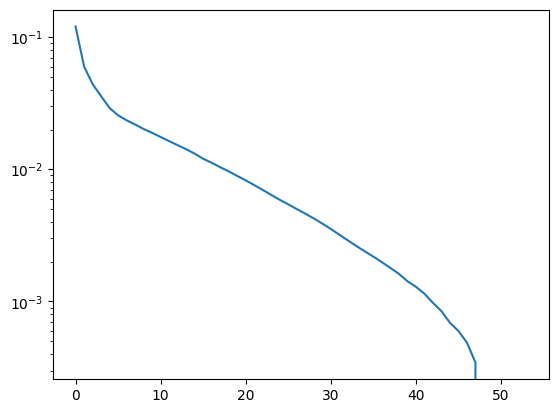

In [17]:
U_svd, S, V_svd = svd(imgs[i, :, :])
# plt.semilogy(S)
plt.semilogy(np.sqrt(np.linalg.norm(S)**2 - np.cumsum(S**2)) / np.linalg.norm(S))

# Visualization

In [2]:
%tensorboard --logdir "../data/output/runs"

# References

1. <a id='r1'></a> De Handschutter, P., Gillis, N., & Siebert, X. (2021). A survey on deep matrix factorizations. Computer Science Review, 42, 100423. https://doi.org/10.1016/j.cosrev.2021.100423
2. <a id='r2'></a> Sun, J., Kong, Q., & Xu, Z. (2022). Deep alternating non-negative matrix factorisation. Knowledge-Based Systems, 251, 109210. https://doi.org/10.1016/j.knosys.2022.109210


